**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import string
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
import warnings

**Load Dataset**

In [2]:
df = pd.read_csv('/content/diabetes.csv')
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# ‚úÖ Missing value checker function
def check_missing_data(df):
    missing = df.isnull().sum()
    total = df.shape[0]
    missing_percent = (missing / total) * 100

    result = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_percent
    }).sort_values(by='Missing Count', ascending=False)

    return result

# ‚úÖ Call the function
print(check_missing_data(df))


                          Missing Count  Missing %
Pregnancies                           0        0.0
Glucose                               0        0.0
BloodPressure                         0        0.0
SkinThickness                         0        0.0
Insulin                               0        0.0
BMI                                   0        0.0
DiabetesPedigreeFunction              0        0.0
Age                                   0        0.0
Outcome                               0        0.0


/tmp/ipython-input-1956166268.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette='Set2')


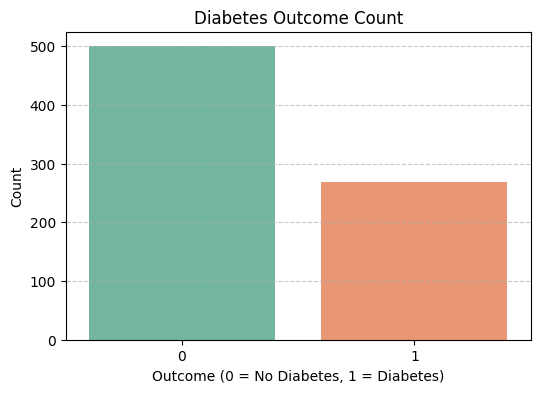

In [5]:
# ‚úÖ Visualization - Outcome Balance
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df, palette='Set2')
plt.title('Diabetes Outcome Count')
plt.xlabel('Outcome (0 = No Diabetes, 1 = Diabetes)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

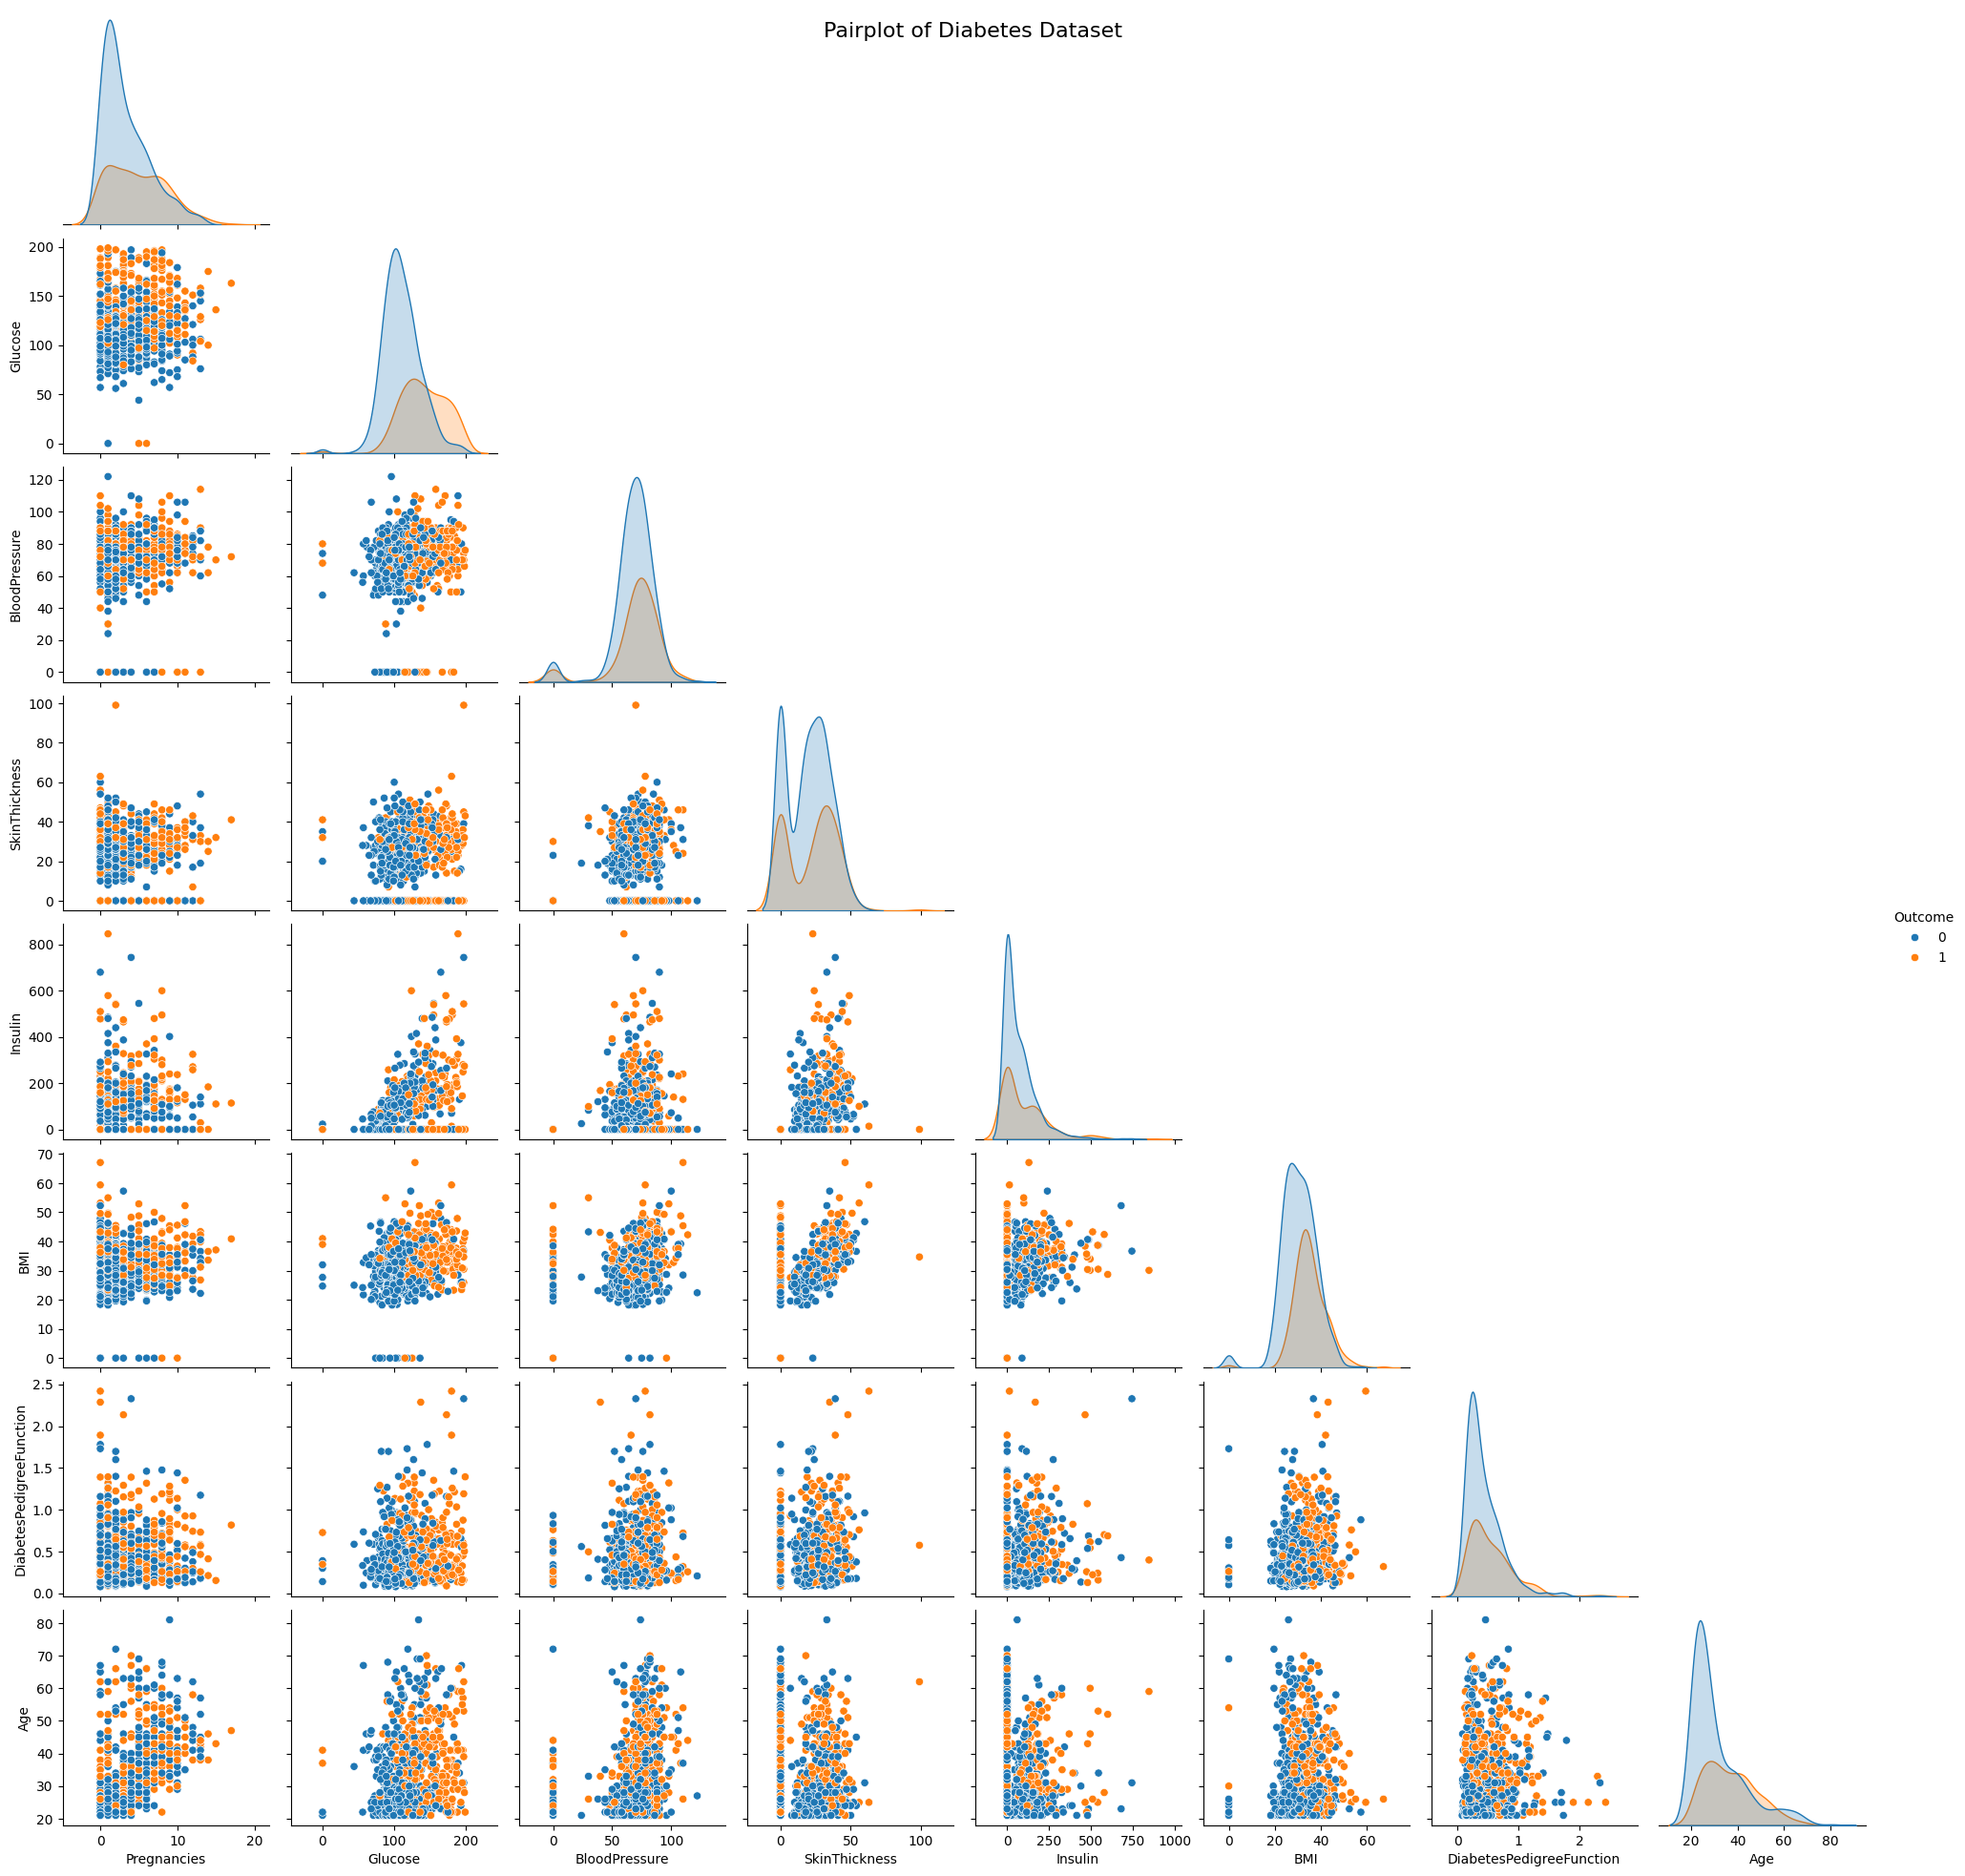

In [10]:
#Pairplot ‡¶Ü‡¶Å‡¶ï‡¶æ
sns.pairplot(data=df, hue='Outcome', corner=True)
plt.suptitle("Pairplot of Diabetes Dataset", fontsize=16)
plt.show()

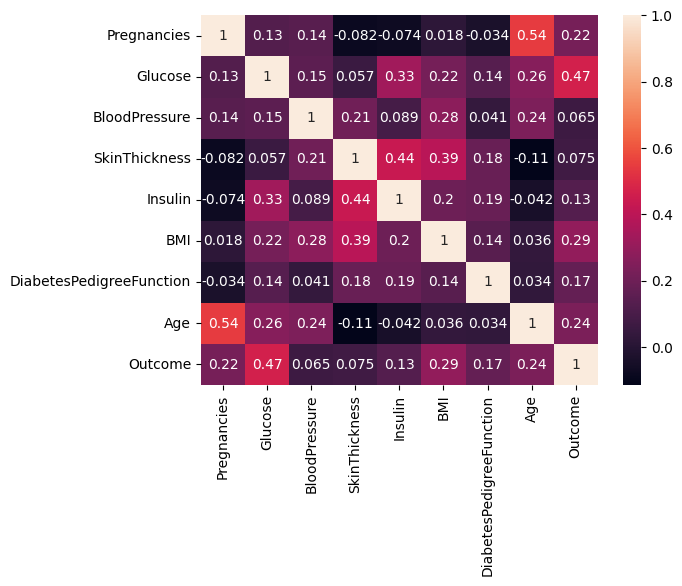

In [11]:
# Heatmap
sns.heatmap(df.corr(), annot = True)
plt.show()

In [12]:
# ‡¶Ø‡ßá‡¶∏‡¶¨ ‡¶ï‡¶≤‡¶æ‡¶Æ‡ßá 0 ‡¶Æ‡¶æ‡¶® invalid, ‡¶∏‡ßá‡¶ó‡ßÅ‡¶≤‡ßã‡¶∞ 0 ‚Üí NaN
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    df[col] = df[col].replace(0, np.nan)

# ‡¶§‡¶æ‡¶∞‡¶™‡¶∞ median ‡¶¶‡¶ø‡ßü‡ßá fill
df.fillna(df.median(numeric_only=True), inplace=True)

**Feature Scaling (Standardization)**

In [13]:
# ‚úÖ Target ‡¶è‡¶¨‡¶Ç Selected Features ‡¶Ü‡¶≤‡¶æ‡¶¶‡¶æ ‡¶ï‡¶∞‡¶æ
selected_features = ['Glucose', 'BMI', 'Age', 'Insulin', 'DiabetesPedigreeFunction',
                     'Pregnancies', 'BloodPressure', 'SkinThickness']

X = df[selected_features]
y = df['Outcome']

# ‚úÖ StandardScaler ‡¶¨‡ßç‡¶Ø‡¶¨‡¶π‡¶æ‡¶∞ ‡¶ï‡¶∞‡ßá ‡¶∏‡ßç‡¶ï‡ßá‡¶≤ ‡¶ï‡¶∞‡¶æ
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ‚úÖ DataFrame ‡¶Ü‡¶ï‡¶æ‡¶∞‡ßá ‡¶∞‡ßÇ‡¶™‡¶æ‡¶®‡ßç‡¶§‡¶∞
scaled_df = pd.DataFrame(X_scaled, columns=selected_features)
scaled_df['Outcome'] = y.values

# ‚úÖ Output ‡¶¶‡ßá‡¶ñ‡¶æ‡¶®‡ßã
print("‚úÖ Feature Scaling ‡¶∏‡¶Æ‡ßç‡¶™‡¶®‡ßç‡¶® ‡¶π‡ßü‡ßá‡¶õ‡ßá‡•§ ‡¶®‡¶ø‡¶ö‡ßá ‡¶∏‡ßç‡¶ï‡ßá‡¶≤ ‡¶ï‡¶∞‡¶æ ‡¶°‡ßá‡¶ü‡¶æ‡¶∞ preview:")
scaled_df.head()

‚úÖ Feature Scaling ‡¶∏‡¶Æ‡ßç‡¶™‡¶®‡ßç‡¶® ‡¶π‡ßü‡ßá‡¶õ‡ßá‡•§ ‡¶®‡¶ø‡¶ö‡ßá ‡¶∏‡ßç‡¶ï‡ßá‡¶≤ ‡¶ï‡¶∞‡¶æ ‡¶°‡ßá‡¶ü‡¶æ‡¶∞ preview:


Glucose       BMI       Age   Insulin  DiabetesPedigreeFunction  \
0  0.866045  0.166619  1.425995 -0.181541                  0.468492   
1 -1.205066 -0.852200 -0.190672 -0.181541                 -0.365061   
2  2.016662 -1.332500 -0.105584 -0.181541                  0.604397   
3 -1.073567 -0.633881 -1.041549 -0.540642                 -0.920763   
4  0.504422  1.549303 -0.020496  0.316566                  5.484909   

   Pregnancies  BloodPressure  SkinThickness  Outcome  
0     0.639947      -0.031990       0.670643        1  
1    -0.844885      -0.528319      -0.012301        0  
2     1.233880      -0.693761      -0.012301        1  
3    -0.844885      -0.528319      -0.695245        0  
4    -1.141852      -2.679076       0.670643        1

**Feature Selection**

In [15]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
# ‚úÖ Feature ‡¶è‡¶¨‡¶Ç Target ‡¶Ü‡¶≤‡¶æ‡¶¶‡¶æ ‡¶ï‡¶∞‡¶æ
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# ‚úÖ SelectKBest + Mutual Information ‡¶¶‡¶ø‡ßü‡ßá Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=8)  # Top 8 feature ‡¶®‡ßá‡¶¨‡ßã
selector.fit(X, y)

# ‚úÖ ‡¶®‡¶ø‡¶∞‡ßç‡¶¨‡¶æ‡¶ö‡¶ø‡¶§ ‡¶´‡¶ø‡¶ö‡¶æ‡¶∞ ‡¶≤‡¶ø‡¶∏‡ßç‡¶ü ‡¶¨‡ßá‡¶∞ ‡¶ï‡¶∞‡¶æ
selected_features = X.columns[selector.get_support()].tolist()
print("üéØ ‡¶®‡¶ø‡¶∞‡ßç‡¶¨‡¶æ‡¶ö‡¶ø‡¶§ Top 8 Features:", selected_features)

# ‚úÖ ‡¶®‡¶§‡ßÅ‡¶® ‡¶°‡ßá‡¶ü‡¶æ‡¶∏‡ßá‡¶ü ‡¶§‡ßà‡¶∞‡¶ø
selected_df = df[selected_features + ['Outcome']]
selected_df.head()

üéØ ‡¶®‡¶ø‡¶∞‡ßç‡¶¨‡¶æ‡¶ö‡¶ø‡¶§ Top 8 Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    125.0  33.6   
1            1     85.0           66.0           29.0    125.0  26.6   
2            8    183.0           64.0           29.0    125.0  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

**Logistic Regression**

‚úÖ Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154

‚úÖ Confusion Matrix:


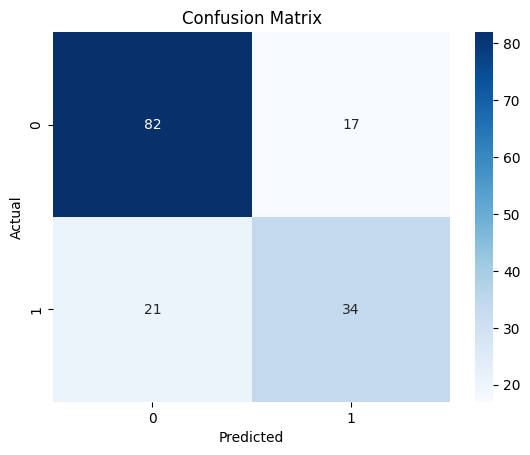

In [17]:

zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    df[col] = df[col].replace(0, np.nan)
df.fillna(df.median(numeric_only=True), inplace=True)

# ‚úÖ Feature ‡¶ì Target ‡¶Ü‡¶≤‡¶æ‡¶¶‡¶æ
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# ‚úÖ Top 8 Feature ‡¶®‡¶ø‡¶∞‡ßç‡¶¨‡¶æ‡¶ö‡¶® (Mutual Information)
selector = SelectKBest(score_func=mutual_info_classif, k=8)
selector.fit(X, y)
selected_columns = X.columns[selector.get_support()]
X_selected = X[selected_columns]

# ‚úÖ Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# ‚úÖ Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ‚úÖ Logistic Regression ‡¶Æ‡¶°‡ßá‡¶≤ ‡¶§‡ßà‡¶∞‡¶ø ‡¶ì ‡¶ü‡ßç‡¶∞‡ßá‡¶®
model = LogisticRegression()
model.fit(X_train, y_train)

# ‚úÖ ‡¶™‡ßç‡¶∞‡ßá‡¶°‡¶ø‡¶ï‡¶∂‡¶®
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# ‚úÖ Report ‡¶ì Confusion Matrix
print("‚úÖ Classification Report:\n")
print(classification_report(y_test, y_pred))

print("‚úÖ Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



**XGBoost**

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:45:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


‚úÖ Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.74      0.77        99
           1       0.59      0.67      0.63        55

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.72       154

‚úÖ Confusion Matrix:


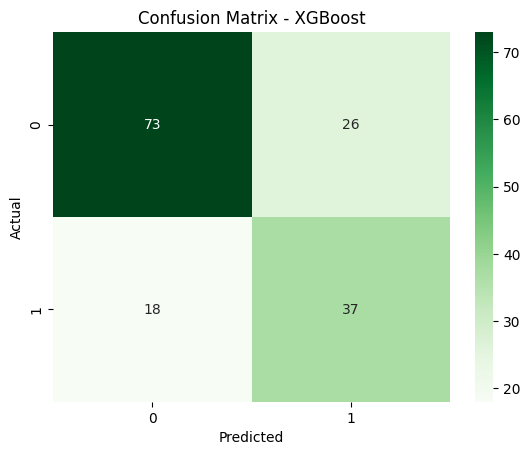

In [20]:
from xgboost import XGBClassifier

zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    df[col] = df[col].replace(0, np.nan)
df.fillna(df.median(numeric_only=True), inplace=True)

# ‚úÖ Feature ‡¶ì Target ‡¶Ü‡¶≤‡¶æ‡¶¶‡¶æ ‡¶ï‡¶∞‡¶æ
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# ‚úÖ Top 8 Feature ‡¶®‡¶ø‡¶∞‡ßç‡¶¨‡¶æ‡¶ö‡¶® (Mutual Information)
selector = SelectKBest(score_func=mutual_info_classif, k=8)
selector.fit(X, y)
selected_columns = X.columns[selector.get_support()]
X_selected = X[selected_columns]

# ‚úÖ Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# ‚úÖ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ‚úÖ XGBoost ‡¶Æ‡¶°‡ßá‡¶≤ Train ‡¶ï‡¶∞‡¶æ
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# ‚úÖ Prediction
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# ‚úÖ Classification Report ‡¶ì Confusion Matrix
print("‚úÖ Classification Report:\n")
print(classification_report(y_test, y_pred))

print("‚úÖ Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


**Random Forest**

‚úÖ Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.79      0.80        99
           1       0.63      0.65      0.64        55

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.74      0.74       154

‚úÖ Confusion Matrix:


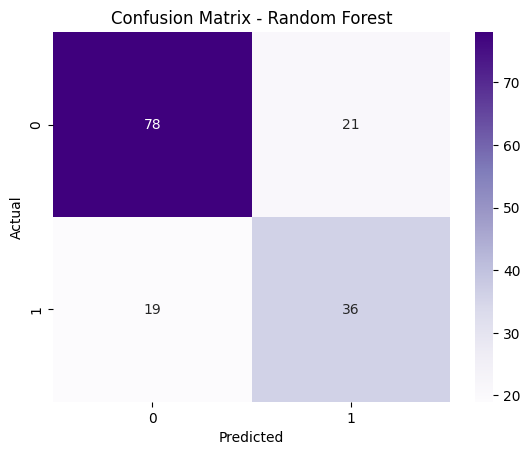

In [22]:
from sklearn.ensemble import RandomForestClassifier

# ‚úÖ Feature ‡¶è‡¶¨‡¶Ç Target ‡¶Ü‡¶≤‡¶æ‡¶¶‡¶æ
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# ‚úÖ Top 8 ‡¶´‡¶ø‡¶ö‡¶æ‡¶∞ ‡¶®‡¶ø‡¶∞‡ßç‡¶¨‡¶æ‡¶ö‡¶® (Mutual Info)
selector = SelectKBest(score_func=mutual_info_classif, k=8)
selector.fit(X, y)
selected_cols = X.columns[selector.get_support()]
X_selected = X[selected_cols]

# ‚úÖ Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# ‚úÖ Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ‚úÖ Random Forest Model Train ‡¶ï‡¶∞‡¶æ
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ‚úÖ Prediction
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# ‚úÖ Report
print("‚úÖ Classification Report:\n")
print(classification_report(y_test, y_pred))

# ‚úÖ Confusion Matrix
print("‚úÖ Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()



**Model Comparison**

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:50:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Model Comparison Table:

                 Model  Accuracy  Precision  Recall  F1 Score     AUC
0        Random Forest    0.7403     0.6316  0.6545    0.6429  0.8334
1  Logistic Regression    0.7532     0.6667  0.6182    0.6415  0.8230
2              XGBoost    0.7143     0.5873  0.6727    0.6271  0.7774


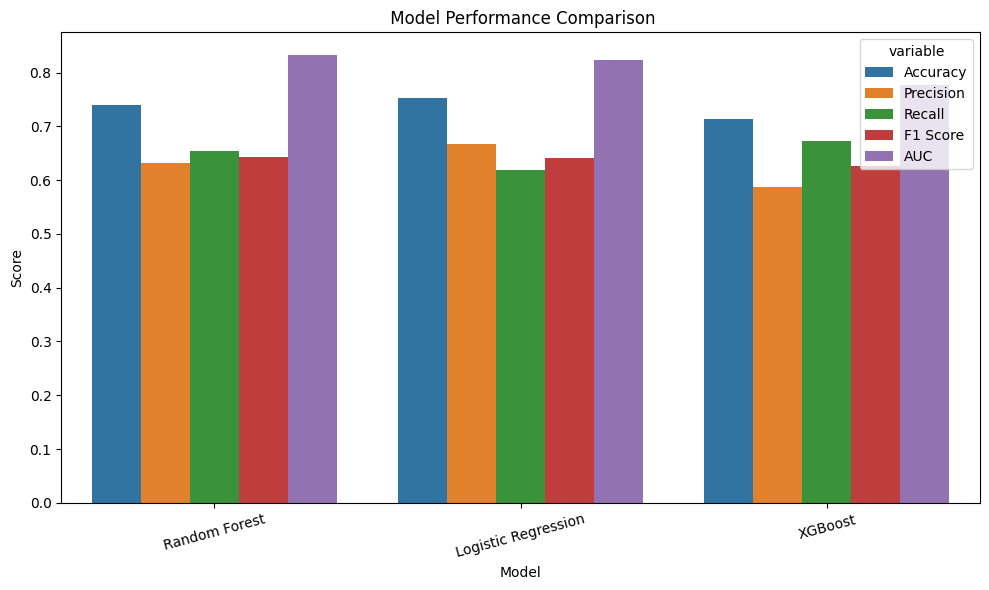

In [23]:
# ‚úÖ ‡¶™‡ßç‡¶∞‡ßü‡ßã‡¶ú‡¶®‡ßÄ‡ßü ‡¶≤‡¶æ‡¶á‡¶¨‡ßç‡¶∞‡ßá‡¶∞‡¶ø
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



# ‚úÖ Feature Selection (Top 8 using Mutual Info)
X = df.drop(columns=['Outcome'])
y = df['Outcome']
selector = SelectKBest(score_func=mutual_info_classif, k=8)
X_selected = selector.fit_transform(X, y)
selected_cols = X.columns[selector.get_support()]

# ‚úÖ Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# ‚úÖ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ‚úÖ ‡¶Æ‡¶°‡ßá‡¶≤ ‡¶§‡¶æ‡¶≤‡¶ø‡¶ï‡¶æ
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# ‚úÖ ‡¶´‡¶≤‡¶æ‡¶´‡¶≤ ‡¶∏‡¶Ç‡¶∞‡¶ï‡ßç‡¶∑‡¶£‡ßá‡¶∞ ‡¶ú‡¶®‡ßç‡¶Ø ‡¶≤‡¶ø‡¶∏‡ßç‡¶ü
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

# ‚úÖ ‡¶∞‡ßá‡¶ú‡¶æ‡¶≤‡ßç‡¶ü ‡¶ü‡ßá‡¶¨‡¶ø‡¶≤ ‡¶Ü‡¶ï‡¶æ‡¶∞‡ßá ‡¶¶‡ßá‡¶ñ‡¶æ‡¶®‡ßã
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by='AUC', ascending=False).reset_index(drop=True)

# ‚úÖ ‡¶ü‡ßá‡¶¨‡¶ø‡¶≤ ‡¶™‡ßç‡¶∞‡¶ø‡¶®‡ßç‡¶ü
print("\n Model Comparison Table:\n")
print(comparison_df.round(4))

# ‚úÖ ‡¶¨‡¶æ‡¶∞ ‡¶ö‡¶æ‡¶∞‡ßç‡¶ü ‡¶≠‡¶ø‡¶ú‡ßÅ‡ßü‡¶æ‡¶≤‡¶æ‡¶á‡¶ú‡ßá‡¶∂‡¶®
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title(' Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
